## Importing the relevant packages

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from arch import arch_model
from math import sqrt
import seaborn as sns
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
sns.set()
#plt.style.available

## Importing the Data and Pre-processing 

In [73]:
raw_csv_data = pd.read_csv("../JPM.US.csv") 
df_comp=raw_csv_data.copy()
df_comp.set_index("Date", inplace=True)

In [74]:
# df_comp['market_value']=df_comp.Close
df_comp.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-02,160.02,161.6100,159.430,160.46,8815634.0
2021-09-03,160.39,160.8900,159.145,159.49,7961223.0
2021-09-07,159.99,161.3814,158.960,159.21,9290968.0
2021-09-08,158.89,159.5800,158.040,158.50,7852678.0
2021-09-09,158.27,160.8325,158.080,159.19,7904256.0


In [75]:
size = 252 #int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:-size], df_comp.iloc[-size:]

In [76]:
df_test

,Open,High,Low,Close,Volume
Date,,,,,
2020-09-10,98.598,99.5900,96.886,97.071,16375437.0
2020-09-11,97.207,98.5580,96.836,98.276,14176195.0
2020-09-14,98.706,100.6000,98.568,99.640,19557988.0
2020-09-15,99.890,100.0000,96.400,96.536,24356220.0
2020-09-16,96.682,98.3350,96.030,96.944,19832440.0
...,...,...,...,...,...
2021-09-02,160.020,161.6100,159.430,160.460,8815634.0
2021-09-03,160.390,160.8900,159.145,159.490,7961223.0
2021-09-07,159.990,161.3814,158.960,159.210,9290968.0


In [77]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [78]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Collerogram plot

In [79]:
def tsplot(y, lags=None, figsize=(10, 8), style='default', title=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Creating Returns

In [80]:
df['Returns'] = df.Close.pct_change(1)*100
df['Returns'].head()

Date
1970-01-02         NaN
1970-01-05    0.000000
1970-01-06    1.058446
1970-01-07    2.373312
1970-01-08   -0.258353
Name: Returns, dtype: float64

## Creating Squared Returns

In [81]:
df['Sq_Returns'] = df.Returns.mul(df.Returns)

In [82]:
df['Sq_Returns'].head()

Date
1970-01-02         NaN
1970-01-05    0.000000
1970-01-06    1.120308
1970-01-07    5.632608
1970-01-08    0.066746
Name: Sq_Returns, dtype: float64

In [83]:
df.tail()

,Open,High,Low,Close,Volume,Returns,Sq_Returns
Date,,,,,,,
2020-09-02,97.187,99.119,96.809,98.844,14887179.0,1.511728,2.285322
2020-09-03,100.460,102.090,97.853,98.528,23943061.0,-0.319696,0.102205
2020-09-04,101.170,102.290,98.568,100.660,27073835.0,2.163852,4.682255
2020-09-08,100.130,100.710,96.730,97.157,22737104.0,-3.480032,12.110621
2020-09-09,98.010,98.884,96.809,98.079,13815918.0,0.948979,0.900562


# Creating log returns

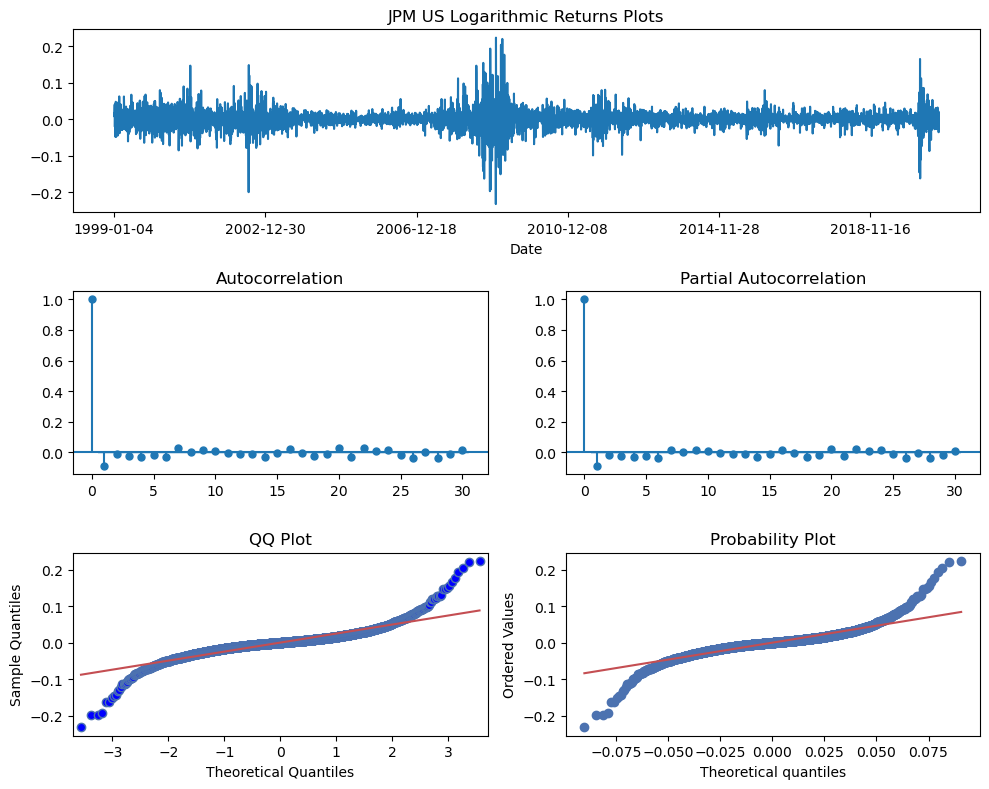

In [104]:
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
#df_proba = df.Log_Ret.loc['1999-01-01':'2020-09-09'].dropna()
#data['Log_Ret'] = np.log(data['Close']).diff().mul(100) # rescale to faciliate optimization
tsplot(df.Log_Returns.loc['1999-01-01':'2020-09-09'], lags=30, title='JPM US Logarithmic Returns Plots')

In [85]:
df['Volatility'] = df['Log_Returns'].rolling(window=252).std() * np.sqrt(252)
df['Volatility'] = df['Volatility'].iloc[252:]

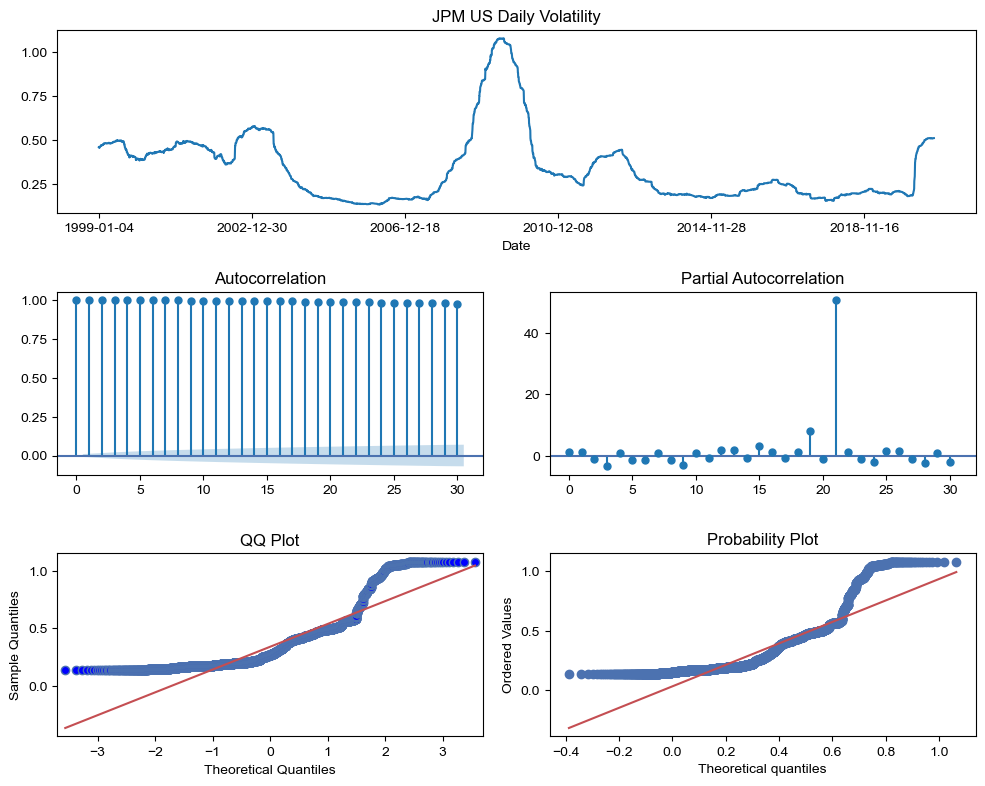

In [86]:
tsplot(df.Volatility.loc['1999-01-01':], lags=30, title='JPM US Daily Volatility')


In [62]:
df = df.iloc[252:]
df

,Open,High,Low,Close,Volume,Returns,Sq_Returns,Log_Returns,Volatility
Date,,,,,,,,,
1970-12-31,3.0605,3.0751,3.0378,3.0605,79279.0,0.000000,0.000000,0.000000,0.228474
1971-01-04,3.0605,3.0751,3.0302,3.0302,67436.0,-0.990034,0.980168,-0.009950,0.228706
1971-01-05,3.0302,3.0605,3.0229,3.0378,55588.0,0.250809,0.062905,0.002505,0.228486
1971-01-06,3.0455,3.0902,3.0455,3.0676,73810.0,0.980973,0.962308,0.009762,0.227500
1971-01-07,3.0676,3.1423,3.0455,3.1423,138508.0,2.435128,5.929851,0.024060,0.228727
...,...,...,...,...,...,...,...,...,...
2020-09-02,97.1870,99.1190,96.8090,98.8440,14887179.0,1.511728,2.285322,0.015004,0.512842
2020-09-03,100.4600,102.0900,97.8530,98.5280,23943061.0,-0.319696,0.102205,-0.003202,0.512353
2020-09-04,101.1700,102.2900,98.5680,100.6600,27073835.0,2.163852,4.682255,0.021408,0.512805


## The Simple GARCH Model

#### Constant mean: generally works well with most financial return data.

In [63]:
model_garch_1_1 = arch_model(df.Log_Returns, mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1 = model_garch_1_1.fit(update_freq = 5)
results_garch_1_1.summary()

Iteration:      5,   Func. Count:     61,   Neg. LLF: -32967.85513156088
Optimization terminated successfully    (Exit mode 0)
            Current function value: -32967.855149986484
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                32967.9
Distribution:                  Normal   AIC:                          -65927.7
Method:            Maximum Likelihood   BIC:                          -65898.0
                                        No. Observations:                12532
Date:                Thu, Sep 16 2021   Df Residuals:                    12531
Time:                        20:09:16   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.3633e-04  3.902e-05     13.744  5.535e-43 [4.599e-04,6.128e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.2571e-06  3.615e-10  2.561e+04      0.000 [9.256e-06,9.258e-06]
alpha[1]       0.1000  1.544e-02      6.477  9.333e-11   [6.974e-02,  0.130]
beta[1]        0.8800  1.102e-02     79.830      0.000     [  0.858,  0.902]
============================================================================

Covariance estimator: robust
"""

## Choosing the best model

In [64]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = df.Log_Returns.loc['1999-01-01':'2020-09-09']
res_tup = _get_best_model(TS)

aic: -24932.17959 | order: (4, 0, 3)


## Fittling the data to the best model

In [65]:
# Now we can fit the arch model using the best fit arima model parameters
best_order = res_tup[1]

p_ = best_order[0]
#o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, q=q_, dist='StudentsT')#, vol="GARCH", mean = "Constant")
res_best_order_arima = am.fit(update_freq=5)
print(res_best_order_arima.summary())

Iteration:      5,   Func. Count:     73,   Neg. LLF: 47303.680745220496
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9463.929938181587
            Iterations: 13
            Function evaluations: 145
            Gradient evaluations: 9
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                9463.93
Distribution:      Standardized Student's t   AIC:                          -18907.9
Method:                  Maximum Likelihood   BIC:                          -18841.8
                                              No. Observations:                 5455
Date:                      Thu, Sep 16 2021   Df Residuals:                     5454
Time:                              20

In [66]:
# Now we can fit the arch model using the best fit arima model parameters
best_order = res_tup[1]

p_ = 1
#o_ = best_order[1]
q_ = 3

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, q=q_, dist='StudentsT')#, vol="GARCH", mean = "Constant")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     56,   Neg. LLF: 9338.517811264266
Iteration:     10,   Func. Count:    119,   Neg. LLF: 2004899.4771062369
Iteration:     15,   Func. Count:    175,   Neg. LLF: 60320.9059172962
Iteration:     20,   Func. Count:    215,   Neg. LLF: 34550.547432956984
Iteration:     25,   Func. Count:    262,   Neg. LLF: 3814.516813073313
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10320.846349907759
            Iterations: 30
            Function evaluations: 271
            Gradient evaluations: 26
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                10320.8
Distribution:      Standardized Student's t   AIC:                          -20627.7
Me

In [105]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                10320.8
Distribution:      Standardized Student's t   AIC:                          -20627.7
Method:                  Maximum Likelihood   BIC:                          -20581.5
                                              No. Observations:                 5455
Date:                      Thu, Sep 16 2021   Df Residuals:                     5454
Time:                              20:11:13   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -9.8853e-03  3.487e-04    -28.350 8.365e-177 [-1.057e-02,-9.202e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.5490e-03  4.938e-05    112.375      0.000 [5.452e-03,5.646e-03]
alpha[1]       0.9380      0.187      5.028  4.950e-07     [  0.572,  1.304]
beta[1]        0.0594  8.362e-02      0.711      0.477     [ -0.104,  0.223]
beta[2]    2.5795e-03      0.208  1.243e-02      0.990     [ -0.404,  0.409]
beta[3]        0.0000      0.168      0.000      1.000     [ -0.328,  0.328]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.1076  9.572e-03    324.660      0.000 [  3.089,  3.126]
========================================================================

Covariance estimator: robust
"""

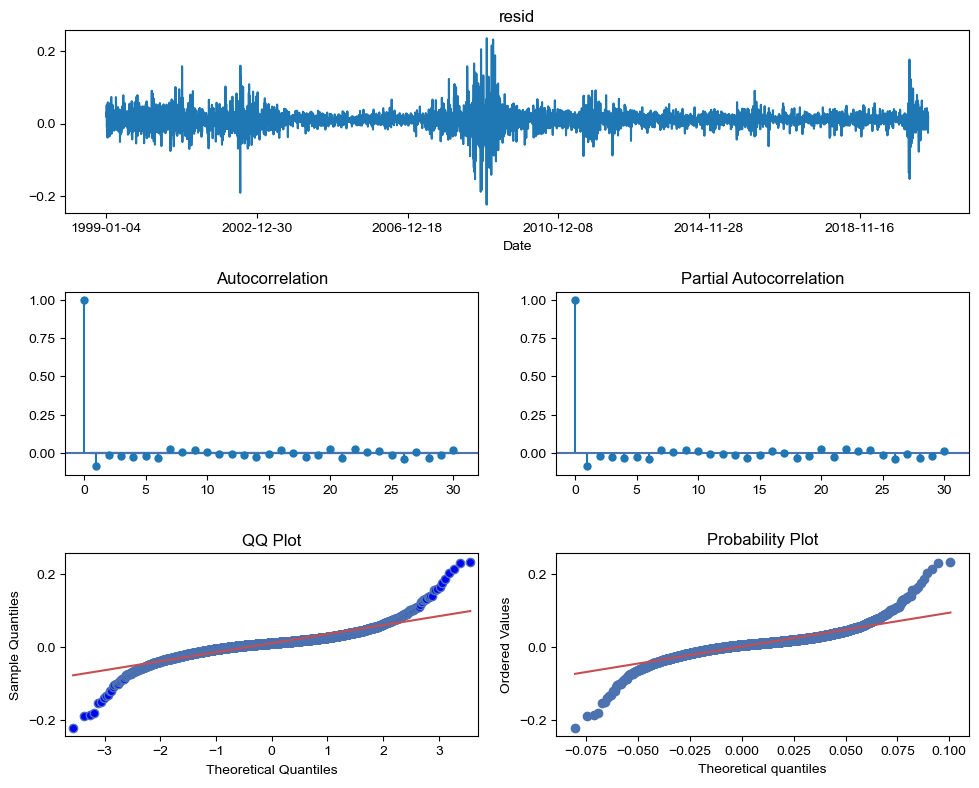

In [67]:
tsplot(res.resid, lags=30, title="resid")

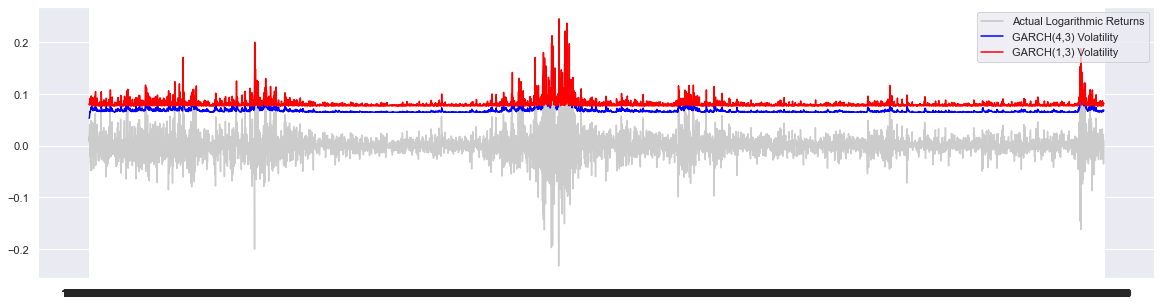

In [89]:
garch_best_order_arima_vol = res_best_order_arima.conditional_volatility
garch_vol = res.conditional_volatility

plt.figure(figsize=(20,5))

# Plot the actual logarithmic returns
plt.plot(df['Log_Returns'].loc['1999-01-01':], color = 'grey', alpha = 0.4, label = 'Actual Logarithmic Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(garch_best_order_arima_vol, color = 'blue', label = 'GARCH(4,3) Volatility')

# Plot EGARCH  estimated volatility
plt.plot(garch_vol, color = 'red', label = 'GARCH(1,3) Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [68]:
# Print each models BIC
print(f'GARCH(4,3) BIC: {res_best_order_arima.bic}')
print(f'\GARCH(1,3) BIC: {res.bic}')

GARCH(4,3) BIC: -18841.8169973805
\GARCH(1,3) BIC: -20581.462684527647


## Forecasting

In [69]:
#import datetime as dt

In [70]:
# forecast the test set
#split_date = dt.datetime(2020,9,9)
res_forecast = res.forecast(horizon=len(df_test), method='simulation', reindex=False)

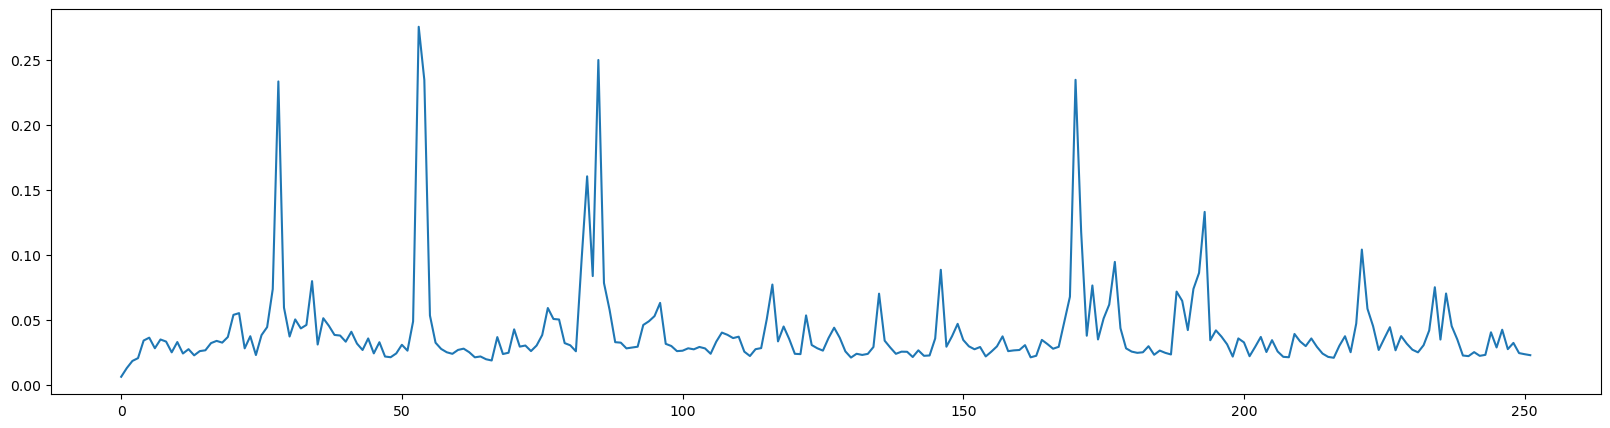

In [88]:
# plot forecast variance
plt.style.use('default')
plt.figure(figsize=(20,5))
plt.plot(res_forecast.variance.values[-1, :])
plt.show()

In [89]:
residuals_forecast = pd.DataFrame(res_forecast.residual_variance)

In [90]:
mean_forecast = pd.DataFrame(res_forecast.mean)

In [91]:
df_test.index

Index(['2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
       '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22', '2020-09-23',
       ...
       '2021-08-26', '2021-08-27', '2021-08-30', '2021-08-31', '2021-09-01',
       '2021-09-02', '2021-09-03', '2021-09-07', '2021-09-08', '2021-09-09'],
      dtype='object', name='Date', length=252)

In [92]:
df_forecast = (residuals_forecast + mean_forecast).transpose()

In [93]:
df_forecast

Date,2020-09-09
h.001,-0.003577
h.002,0.003104
h.003,0.008591
h.004,0.010753
h.005,0.024270
...,...
h.248,0.017653
h.249,0.022447
h.250,0.014622
h.251,0.013768


In [95]:
df_forecast.columns.name = df_forecast.index.name
df_forecast

,2020-09-09
h.001,-0.003577
h.002,0.003104
h.003,0.008591
h.004,0.010753
h.005,0.024270
...,...
h.248,0.017653
h.249,0.022447
h.250,0.014622
h.251,0.013768


In [96]:
df_forecast = df_forecast.set_index(df_test.index)
df_forecast.columns.name = df_forecast.index.name
df_forecast.index.name = None
df_forecast

Date,2020-09-09
2020-09-10,-0.003577
2020-09-11,0.003104
2020-09-14,0.008591
2020-09-15,0.010753
2020-09-16,0.024270
...,...
2021-09-02,0.017653
2021-09-03,0.022447
2021-09-07,0.014622
2021-09-08,0.013768


In [97]:
df_forecast = df_forecast.rename({'2020-09-09':'Predictions'}, axis=1)
#df_forecast.names=['Date']
df_forecast

Date,Predictions
2020-09-10,-0.003577
2020-09-11,0.003104
2020-09-14,0.008591
2020-09-15,0.010753
2020-09-16,0.024270
...,...
2021-09-02,0.017653
2021-09-03,0.022447
2021-09-07,0.014622
2021-09-08,0.013768


<AxesSubplot:>

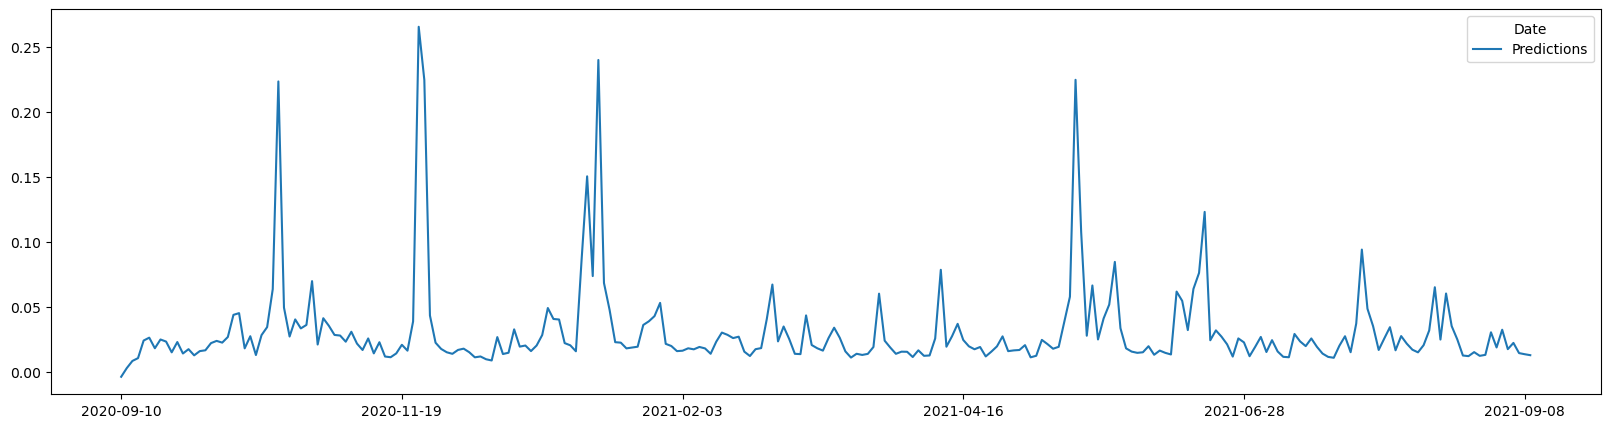

In [98]:
df_forecast.plot(figsize=(20,5))

In [99]:
df_test['Log_Returns'] = np.log(df_test['Close'] / df_test['Close'].shift(1))

In [100]:
df_forecast['Log_Returns'] = df_test['Log_Returns']

<AxesSubplot:>

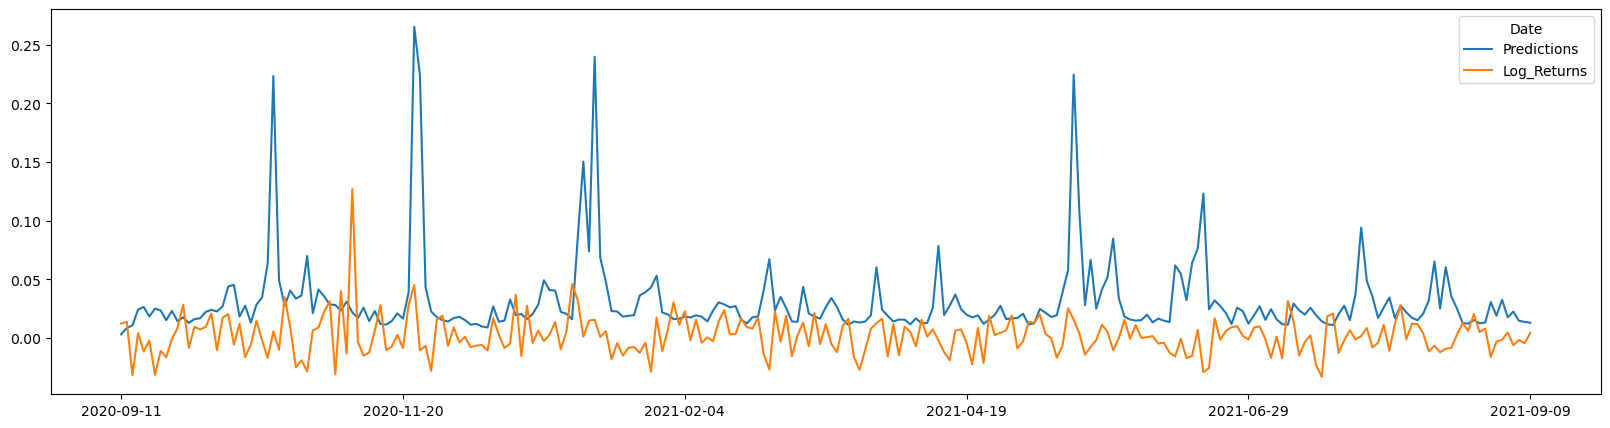

In [101]:
df_forecast[1:].plot(figsize=(20,5))

In [102]:
    #MSE
    print(np.mean(np.square(df_forecast['Predictions'] - df_forecast['Log_Returns'])))
    #MAE
    print(np.mean(np.abs(df_forecast['Predictions'] - df_forecast['Log_Returns'])))
    #MAPE
    print(np.mean(np.abs((df_forecast['Log_Returns'] - df_forecast['Predictions']) / df_forecast['Log_Returns'])))

0.002298416339284609
0.0318513561938198
8.657018395389123


In [81]:
pd.DataFrame(res.params)

,params
mu,-0.009885
omega,0.005549
alpha[1],0.937990
beta[1],0.059428
beta[2],0.002579
beta[3],0.000000
nu,3.107584


<AxesSubplot:>

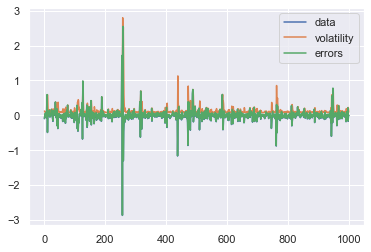

In [82]:
sim_mod = arch_model(None, p=p_, q=q_, dist="StudentsT")

sim_data = sim_mod.simulate(res.params, 1000)
sim_data.plot()